### 전이 학습으로 영화 리뷰 텍스트의 감성 분류하기 목차
* [Chapter 1 트랜스포머 인코더 기반 언어 이해 모델 - BERT)](#chapter1)
* [Chapter 2 어텐션 메커니즘](#chapter2)
   * [Section 2.1 셀프 어텐션](#section_2_1)
   * [Section 2.2 멀티 헤드 어텐션](#section_2_2)
* [Chapter 3 위치 인코딩과 층 정규화](#chapter3)
* [Chapter 4 트랜스포머 인코더만들기](#chapter4)

### Chapter 1 트랜스포머 인코더 기반 언어 이해 모델 - BERT <a class="anchor" id="chapter1"></a>
1. BERT(Bidirectional Encoder Representations from Transformers)
   - 구글이 2018년에 발표한 트랜스포머 인코더 기반의 대규모 언어모델(LLM Large Language Model)
   - 이전 모델들이 한 방향으로만 단어를 이해한 것과 달리, 단어의 양방향 문맥을 동시에 학습
   - 대규모 텍스트 데이터를 활용해 사전 학습을 수행한 뒤, 다양한 자연어 처리 작업에 쉽게 적용 할 수 있는 범용 모델로 설계
   - 두 가지 사전 훈력 방식 사용
      - 입력 데이터의 일부 토큰을 가린(마스킹Masking)다음, 모델이 가려진 단어를 예측하는 마스크드 언어 모델링(MLM Masked Language Modeling)
      - 두 문장이 제시됐을 때 두 번재 문장이 첫번째 문장에 이어지는 다음 문장인지를 예측하는 다음 문장 예측(NSP Next Sentence Prediction)
2. 자연어 처리 모델에서는 학습된 출력 벡터를 기반으로 수행되는 별도의 분류기를 제외한 다른 나머지 부분들을 조종 백본(Backbone) 또는 베이스(base)라고 부른다.
3. BERT 모델은 여러 개의 트랜스포머 인코더 블록을 포함하고 있는 BERT 백본과 분류기로 구성되어있다.
   - 입력 구성
      - 가장 왼쪽의 입력은 세 가지 임베딩을 더해 구성된다.
         - 다음 문장 예측(NSP) 작업을 위해 두 개의 문장을 구분하여 입력
         - 세그먼트 임베딩: 각 토큰이 두 개의 문장 중 어디에 속하는지 구분을 위해 각 단어에 문장 1 또는 문장 2임을 나타내는 정보를 추가
         - 토큰 임베딩: 각 단어를 고정된 길이의 벡터로 변환
         - 위치 임베딩: 문장 내 단어의 순서를 나타내는 위치 정보를 추가
   - 트랜스포머 인코더 블록
      - BERT 백본의 핵심은 반복적으로 쌓아 올린 트래스포머 인코더이다.
      - 멀티 헤드 어텐션, 피드 포워드 네트워크, 층 정규화로 구성된다.
      - 여러 개의 트랜스포머 인코더 블록을 거쳐 처리된 출력은 tanh 활성화 함수를 가진 밀집층을 통화한다.
   - 분류기
      - 주어진 문제의 클래스 개수만큼 출력을 만들어 분류 작업을 수행한다.

    ![BERT](image/04-02-BERT.png)   

    4. GELU(Gaussian Error Linear Unit)
       - OpenAI GPT 모델에서 사용되는 활성화 함수
       - 입력 값 x에 표준 정규 분포의 누적 분포 함수(CDF Cumulative Distribution Function)를 곱해 출력
       - 수식: x * P(X <= x) = x * 0.5(1 + tanh[sqrt(2/pi)(x + 0.044715x^3)])
       - ReLU와 유사하지만, 입력이 음수일 때도 작은 값을 출력
       - 입력이 음수일 때도 작은 값을 출력하기 때문에 ReLU보다 더 부드러운 곡선을 가진다.
       - BERT 모델에서는 GELU가 ReLU보다 더 나은 성능을 보인다.

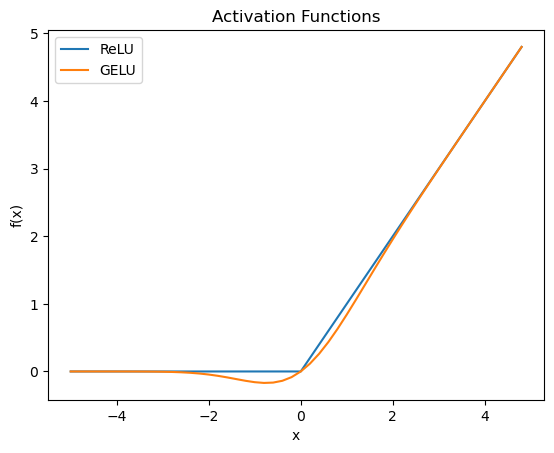

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

# GELU 함수 시각화
# 0.2 간격으로 -5~5 구간의 값 생성
x = np.arange(-5, 5, 0.2)

# 그래프 그리기
# x축: x, y축: clip(0)와 gelu(x)
plt.plot(x, x.clip(0), label='ReLU') # ReLU 함수
plt.plot(x, gelu(x), label='GELU') # GELU 함수
plt.legend()
plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [ ]:
import keras_nlp

# BERT base 모델 규격 
vocab_size = 30522 # BERT base 모델의 단어 집합 크기=
num_layers = 12 # BERT base 모델의 인코더 층 수
num_heads = 12 # BERT base 모델의 멀티 헤드 어텐션 헤드 수
hidden_dim = 768 # BERT base 모델의 숨겨진 차원 수
dropout = 0.1 # BERT base 모델의 드롭아웃 비율
activation = 'gelu' # BERT base 모델의 활성화 함수
max_seq_len = 512 # BERT base 모델의 최대 시퀀스 길이

In [7]:
import keras 
from keras import layers

def transformer_encoder(x, padding_mask, dropout, activation='relu'):
     residual = x
     key_dim = hidden_dim // num_heads
     
     # 배치에 있는 샘플 시퀸스 길이가 다른 경우, 짧은 시퀴스에 0 패딩을 추가하여 동일하게 맞춤
     # padding_mask: 0 패딩을 무시하기 위해 1과 0으로 이루어진 마스크
     x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query=x, value=x, attention_mask=padding_mask)
     
     # 잔차 드롭아웃: 스킵 연결 직전에 통과하는 드롭아웃 층
     x = layers.Dropout(dropout)(x)
     
     # 스킵 연결: 입력을 출력에 더해줌
     x = x + residual
     x = layers.LayerNormalization()(x)
     residual = x
     
     # 두 개의 밀집층으로 이루어진 피드 포워드 신경망
     x = layers.Dense(hidden_dim * 4, activation=activation)(x)
     x = layers.Dense(hidden_dim)(x)
     x = layers.Dropout(dropout)(x)
    
     x = x + residual
     x = layers.LayerNormalization()(x)
     return x

In [9]:
import keras 
from keras import layers

# 입력층 토큰, 세크먼트, 패딩 마스크
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

# 토큰 입력을 사용해 토큰 임베딩, 위치 임베딩, 세그먼트 임베딩 생성
token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)

# 위치 임베딩 - 삼각함수 대신 위치 임베딩 층을 사용해 위치 임베딩 생성
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

# 세그먼트 임베딩 - 다음 문장 예측을 위해 입력되는 문장의 개수가 두 개이므로 크기는 2
segment_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

# 토큰 임베딩, 위치 임베딩, 세그먼트 임베딩을 더하고 층 정규화와 드롭아웃 적용
x = layers.Add()([token_embedding, pos_embedding, segment_embedding])
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

# BERT base 모델은 12개의 트랜스포머 인코더 층을 쌓음
for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

# 트랜스포머 인코더 출력의 첫 번째 토큰에 분류 작업에 대한 결과가 저장되어 있다.
#   - 밀집층을 호출 할 때 x[:, 0, :]로 첫 번째 토큰의 출력만 선택
outputs = layers.Dense(hidden_dim, activation='tanh')(x[:, 0, :]) 
model = keras.Model([token_ids, segment_ids, padding_mask], outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │ 23,440,896 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 768) │    393,216 │ embedding_1[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 768) │      1,536 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding_1[0][0… │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_5[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)